# Uncovering the Liars in the Political Scene of America

This notebook will present a data analysis task on the "Liar, Liar Pants on Fire" dataset, available for download [there](https://www.cs.ucsb.edu/˜william/data/liar_dataset.zip), in the framework of a project for the class "Applied Data Analysis" at EPFL. More precisely, it will present the work done for milestone 2 and a plan up until milestone 3.

### Table of contents:
* [Loading phase](#loading-phase)
* [Cleaning phase](#cleaning-phase)
* [Loading additional files](#loading-additional-files)
* [Data analysis](#data-analysis)
    * [Bar chart](#bar-chart)
    * [Relative importance of each feature](#relative-importance)
    * [Map visualization](#map-visualization)
* [Plan for milestone 3](#plan-ms-3)

In [1]:
# Imports
import pandas as pd
import numpy as np
import json
import folium
import ipywidgets as ipw
import html
import matplotlib.pyplot as plt

## Loading phase <a class="anchor" id="loading-phase"></a>

The liar dataset is composed of three different datasets, namely `test.tsv`, `train.tsv` and `valid.tsv`, which we first load into Pandas dataframes with corresponding names. All of these datasets have exactly the same schema. The purpose of having three different datasets is to do machine learning, which is not the goal of this project. In consequence, we will combine all three dataframes `test`, `train` and `valid` into a single one, `liar`.

The schema of these datasets is outlined below. There is a total of 14 columns and each row refers to a statement.

> Column 1: ID of the statement ([ID].json).
> 
> Column 2: Label.
> 
> Column 3: Statement.
> 
> Column 4: Subject(s).
> 
> Column 5: Speaker.
> 
> Column 6: Speaker's job title.
> 
> Column 7: State info.
> 
> Column 8: Party affiliation.
> 
> Column 9: Barely true counts.
> 
> Column 10: False counts.
> 
> Column 11: Half true counts.
> 
> Column 12: Mostly true counts.
> 
> Column 13: Pants on fire counts.
> 
> Column 14: Context (venue / location of the speech or statement).

In order to reduce the size of the dataframe, we could drop the columns which we do not need. Note that this is not required because the dataset is rather small, but could be done simply for the sake of convenience. However, we will probably need all columns, so no action will be taken there.

In [2]:
DATA_DIR = 'data/'
SCHEMA = ['statement_id', 'label', 'statement', 'subject', 
          'speaker', 'profession', 'state', 'party', 
          'barely_true', 'false', 'half_true', 
          'mostly_true', 'pants_on_fire', 'context']

# Load the datasets into pandas dataframes
test = pd.read_csv(DATA_DIR + 'test.tsv', delimiter='\t', header=None, names=SCHEMA, index_col=False)
train = pd.read_csv(DATA_DIR + 'train.tsv', delimiter='\t', header=None, names=SCHEMA, index_col=False)
valid = pd.read_csv(DATA_DIR + 'valid.tsv', delimiter='\t', header=None, names=SCHEMA, index_col=False)


# Combine the three dataframes into one
liar = pd.concat([train, test, valid], ignore_index=True)

In [3]:
# Display the dataframe
liar.head(3)

,statement_id,label,statement,subject,speaker,profession,state,party,barely_true,false,half_true,mostly_true,pants_on_fire,context
0,2635.json,false,Says the Annies List political group supports ...,abortion,dwayne-bohac,State representative,Texas,republican,0.0,1.0,0.0,0.0,0.0,a mailer
1,10540.json,half-true,When did the decline of coal start? It started...,"energy,history,job-accomplishments",scott-surovell,State delegate,Virginia,democrat,0.0,0.0,1.0,1.0,0.0,a floor speech.
2,324.json,mostly-true,"Hillary Clinton agrees with John McCain ""by vo...",foreign-policy,barack-obama,President,Illinois,democrat,70.0,71.0,160.0,163.0,9.0,Denver


We can check that the three datasets are different (which they should based on their purpose):

In [4]:
liar['statement_id'].is_unique

True

## Cleaning phase <a class="anchor" id="cleaning-phase"></a>

This dataset id very clean by nature because it is not just a collection of data. Indeed, it was intended for use by other data scientists as a benchmark dataset and it will therefore not need many data cleaning operations. We can start by checking if every row is complete or if there are any NaNs or missing values.

In [5]:
liar.isna().any()

statement_id     False
label            False
statement        False
subject           True
speaker           True
profession        True
state             True
party             True
barely_true       True
false             True
half_true         True
mostly_true       True
pants_on_fire     True
context           True
dtype: bool

It appears that most of the columns, more precisely column 4 to 15, do have missing values. However, we will not drop every row where there are NaNs because the other fields in these rows might still be useful.

We will now investigate how the data is formatted to check for potential inconcistencies. We can start with the column concerning the state where the statement was made, because we can have a fairly good idea of what it should contain (i.e. names of locations like states or countries).

In [6]:
liar.state.unique()

array(['Texas', 'Virginia', 'Illinois', nan, 'Florida', 'Wisconsin',
       'New Jersey', 'Vermont', 'Massachusetts', 'Maryland',
       'Washington, D.C. ', 'Oregon', 'New York', 'Washington, D.C.',
       'California', 'Missouri', 'Rhode Island', 'West Virginia',
       'Arkansas', 'New Hampshire', 'Ohio', 'Georgia', 'Arizona',
       'Wyoming', 'Delaware', 'Kentucky', 'Kansas', 'ohio', 'Colorado',
       'North Carolina', 'New Mexico', 'Illinois ', 'Alaska',
       'South Carolina', 'Minnesota', 'Tennessee', 'Pennsylvania', 'Iowa',
       'Connecticut', 'Louisiana', 'Indiana', 'Florida ', 'Utah',
       'Michigan', 'Oklahoma', 'Nevada', 'Oregon ', 'Virgina', 'Nebraska',
       'Georgia ', 'None', 'Washington D.C.', 'California ',
       'Massachusetts ', 'Alabama', 'Russia', 'Washington state',
       'Washington', 'District of Columbia', 'Unknown', 'Colorado ',
       'New Hampshire ', 'Mississippi', 'Rhode island', 'China',
       'United Kingdom', 'Virginia ', 'South Dakota', 'Qa

As we can see, there are inconcistencies in the use of upper case (e.g. `Ohio` and `ohio`) and problems with trailing spaces (e.g. `Georgia` and `Georgia  `). We can take care of these issues by making everything lower case and removing leading and trailing spaces.

In [7]:
def clean(s):
    '''
    Replaces upper case letters by lower case ones and removes leading and trailing spaces.
    :param s: str
    :return: s
    '''
    if isinstance(s, str):
        s = s.lower()\
             .strip()
    return s

In [8]:
# Number of rows before dropping "all Nans" rows
print('Number of unique entities in "state" before applying "clean": %s'%liar.state.unique().shape[0])

liar['state'] = liar['state'].apply(clean)

# Number of rows before dropping "all Nans" rows
print('Number of unique entities in "state" after  applying "clean": %s'%liar.state.unique().shape[0])

Number of unique entities in "state" before applying "clean": 86
Number of unique entities in "state" after  applying "clean": 70


Note that there are still other issues with the data, but we will not take care of them. For example, there are spelling mistakes (e.g. `virgiia` instead of `virginia`). We will ignore them because we can assume that these spelling mistakes will concern only one statement, which means it is not worth taking the time to take care of that kind of issues.

In order to clean the other columns in liar, we will use the same function as above, `clean`. We can indeed assume that they might suffer from the same inconsistencies. It is important to point out that we will not touch to the column `statement` because we want to keep all statements as they were originally written. If we were to modify them, then all conclusions from the analysis of the statements themselves would loose credibility.

In [9]:
for col_name in liar.columns:
    if not (col_name == 'statement'):
        liar[col_name] = liar[col_name].apply(clean)

We can now take a final look at our cleaned `liar` dataframe.

In [10]:
# Display the dataframe
liar.head(3)

,statement_id,label,statement,subject,speaker,profession,state,party,barely_true,false,half_true,mostly_true,pants_on_fire,context
0,2635.json,false,Says the Annies List political group supports ...,abortion,dwayne-bohac,state representative,texas,republican,0.0,1.0,0.0,0.0,0.0,a mailer
1,10540.json,half-true,When did the decline of coal start? It started...,"energy,history,job-accomplishments",scott-surovell,state delegate,virginia,democrat,0.0,0.0,1.0,1.0,0.0,a floor speech.
2,324.json,mostly-true,"Hillary Clinton agrees with John McCain ""by vo...",foreign-policy,barack-obama,president,illinois,democrat,70.0,71.0,160.0,163.0,9.0,denver


## Loading additional files <a class="anchor" id="loading-additional-files"></a>

In order to create maps using folium displaying content from the `liar` dataframe, a new column with the abbreviations of the states will be added. The pairs state name/abbreviations are all contained in the file `states_abbreviation.csv`, which can be downloaded [here](http://www.fonz.net/blog/archives/2008/04/06/csv-of-states-and-state-abbreviations/).

In [11]:
# load the file 'states_abbreviation.csv' into a dataframe
states_abbreviation = pd.read_csv(DATA_DIR + 'states_abbreviation.csv')

# Make sure we have the same format than in liar
states_abbreviation['State'] = states_abbreviation['State'].apply(clean)

i = 0
for state_name in liar['state']:
    temp = states_abbreviation.Abbreviation[state_name==states_abbreviation.State].values
    if temp.size != 0:
        liar.at[i, 'state_abbreviation'] = temp[0]
    else:
        liar.at[i, 'state_abbreviation'] = np.nan
    i+=1

In [12]:
# Display the dataframe
liar.head(3)

,statement_id,label,statement,subject,speaker,profession,state,party,barely_true,false,half_true,mostly_true,pants_on_fire,context,state_abbreviation
0,2635.json,false,Says the Annies List political group supports ...,abortion,dwayne-bohac,state representative,texas,republican,0.0,1.0,0.0,0.0,0.0,a mailer,TX
1,10540.json,half-true,When did the decline of coal start? It started...,"energy,history,job-accomplishments",scott-surovell,state delegate,virginia,democrat,0.0,0.0,1.0,1.0,0.0,a floor speech.,VA
2,324.json,mostly-true,"Hillary Clinton agrees with John McCain ""by vo...",foreign-policy,barack-obama,president,illinois,democrat,70.0,71.0,160.0,163.0,9.0,denver,IL


Finally, we will also load two additional datasets, `pop-urban-pct-historical.xls` and `federalelections2016.xlsx`, which will have the purpose of highlighting potential explanations for the distribution of fake news across America. They are available for download respectively [there](https://www.icip.iastate.edu/tables/population/urban-pct-states) and [there](https://transition.fec.gov/pubrec/electionresults.shtml). For the same reason as earlier, we will add a column with the abbreviations of the states.

In [13]:
# Load pop-urban-pct-historical.xls
states_urban = pd.read_excel(DATA_DIR + 'pop-urban-pct-historical.xls', sheet_name='States',
                             header=5, usecols='B:G,I:M,O:P')
states_urban = states_urban[1:52]

# Make sure we have the same format than in states_abbreviation
states_urban['Area Name'] = states_urban['Area Name'].apply(clean)

# Add the states abbreviations
i = 1
for state_name in states_urban['Area Name']:
    temp = states_abbreviation.Abbreviation[state_name==states_abbreviation.State].values
    if temp.size != 0:
        states_urban.at[i, 'state_abbreviation'] = temp[0]
    else:
        states_urban.at[i, 'state_abbreviation'] = np.nan
    i+=1

In [14]:
# Display the dataframe
states_urban.head(3)

,Area Name,1900,1910,1920,1930,1940,1950,1960,1970,1980,1990,2000,2010,state_abbreviation
1,alabama,11.9,17.3,21.7,28.1,30.2,43.8,54.8,58.6,60.0,60.4,55.4,59.0,AL
2,alaska,24.5,9.5,5.6,13.2,24.0,26.6,37.9,56.9,64.3,67.5,65.6,66.0,AK
3,arizona,15.9,31.0,36.1,34.4,34.8,55.5,74.5,79.6,83.8,87.5,88.2,89.8,AZ


In [15]:
# Load federalelections2016.xlsx
states_election = pd.read_excel(DATA_DIR + 'federalelections2016.xlsx', sheet_name=15,
                                header=6, usecols='A:B,E,H,K,N,Q')
states_election = states_election[1:52]
states_election = states_election.rename(columns={"CLINTON": 2016, "OBAMA": 2012,
                                                  "OBAMA.1": 2008, "KERRY": 2004,
                                                  "GORE": 2000, "CLINTON.1": 1996})

# Make sure we have the same format than in states_abbreviation
states_election['STATE'] = states_election['STATE'].apply(clean)

# Add the states abbreviations
i = 1
for state_name in states_election['STATE']:
    temp = states_abbreviation.Abbreviation[state_name==states_abbreviation.State].values
    if temp.size != 0:
        states_election.at[i, 'state_abbreviation'] = temp[0]
    else:
        states_election.at[i, 'state_abbreviation'] = np.nan
    i+=1

In [16]:
# Display the dataframe
states_election.head(3)

,STATE,2016,2012,2008,2004,2000,1996,state_abbreviation
1,alabama,0.343579,0.38359,0.3874,0.3684,41.57,43.16,AL
2,alaska,0.365509,0.408127,0.3789,0.3552,27.67,33.27,AK
3,arizona,0.45126,0.445898,0.4512,0.444,44.73,46.52,AZ


## Data analysis <a class="anchor" id="data-analysis"></a>

After the initialization with the loading and cleaning phases, we can start the data anlysis _per se_. First, we will create a simple bar chart showing the number of statements made in each states. Then, we will create a visualization tool to understand which feature plays an important role. Finally, we will look at the geographical distribution of fake news and try to correlate it with additional data.

### Bar chart <a class="anchor" id="bar-chart"></a>

The goal here is to get a first idea of how many statements were made in each states. For that, we will make a stacked bar chart showing the number of statements for every label and for each states. Note that we will consider here only american states.

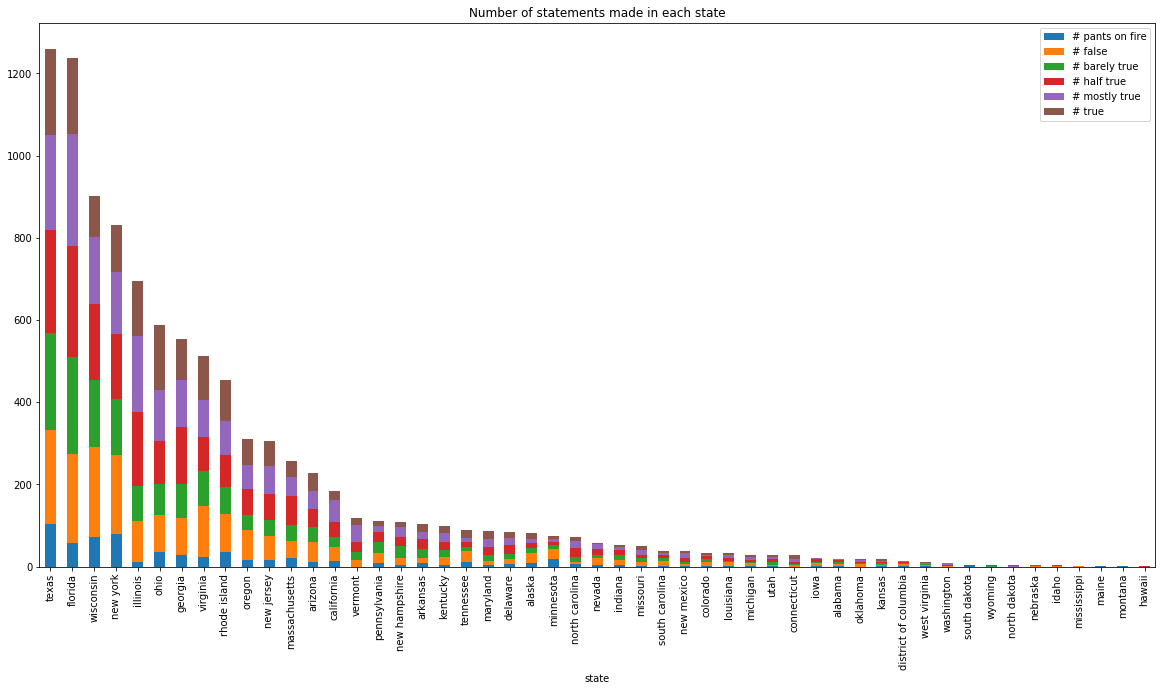

In [17]:
# Get a dataframe with the number of statements for each state and for each label
state_count = liar.dropna(subset=['state_abbreviation'])\
                  .groupby(['state','label'])\
                  .count()\
                  .reset_index()\
                  .filter(['state', 'label', 'statement_id'])\
                  .rename(columns={'statement_id':'#'})

# Get a dataframe for each label with the number of statements for each state
df_total       = liar.dropna(subset=['state_abbreviation']).groupby('state').count().filter(['statement_id']).rename(columns={'statement_id':'#_total'})
df_pants_fire  = state_count[state_count['label']=='pants-fire'] .drop('label', axis=1).set_index('state')
df_false       = state_count[state_count['label']=='false']      .drop('label', axis=1).set_index('state')
df_barely_true = state_count[state_count['label']=='barely-true'].drop('label', axis=1).set_index('state')
df_half_true   = state_count[state_count['label']=='half-true']  .drop('label', axis=1).set_index('state')
df_mostly_true = state_count[state_count['label']=='mostly-true'].drop('label', axis=1).set_index('state')
df_true        = state_count[state_count['label']=='true']       .drop('label', axis=1).set_index('state')

# Join all dataframes together
temp1 = df_total.join(df_pants_fire, how='outer')\
                .join(df_false, how='outer', rsuffix=' false')\
                .join(df_barely_true, how='outer', rsuffix=' barely true')\
                .join(df_half_true, how='outer', rsuffix=' half true')\
                .join(df_mostly_true, how='outer', rsuffix=' mostly true')\
                .join(df_true, how='outer', rsuffix=' true')\
                .rename(columns={'#':'# pants on fire'})\
                .fillna(0)\
                .sort_values(by=['#_total'], ascending=False)\
                .drop('#_total', axis=1)

# Create a stacked plot
temp1.plot.bar(stacked=True, title='Number of statements made in each state', figsize=(20,10));

We can see that the number of statements is varying greatly between states. It is uncertain whether this distribution is representative of the real distribution or results from the way the statements are collected. This might make the comparison between states uneasy if not totally meaningless.

### Relative importance of each feature <a class="anchor" id="relative-importance"></a>

In order to investigate and visualize the data contained in `liar`, we can create a widget which takes as inputs each of the different metadata associated to a statement and returns as output the number of statements which have this set of metadata. This will help understanding how important every features (like profession, subject, etc.) of the statements are and also help finding interesting patterns.

Before we can do that, we have to define a function which will be able to retrieve only the most relevant and occurent values for each feature. For example, for the parties, we will care about the Republicans and the Democrats but less about other minor entities.

In [18]:
def find_top_x(col_name, x, sorted=False):
    '''
    Returns a sorted (if needed) list of the top x entities with the most occurencies in the column specified by col_name.
    :param col_name: str, x: int, sorted: bool
    :return: top_ten
    '''
    # Get the top x
    top_x = liar[['statement_id', col_name]].groupby(col_name)\
                                            .count()\
                                            .sort_values('statement_id', ascending=False)\
                                            .head(x)\
                                            .index\
                                            .values\
                                            .astype('str')
    
    # Create an array of tupple where the first element is like the second but its dashes are replaced by spaces and each word is capitalized
    top_x = [(s.replace('-', ' ').title(), s) for s in top_x]
    
    # If sorted is True, sort the list by alphabetical order
    if sorted:
        top_x.sort(key=lambda x: x[0])
    return top_x

Now we have everything we need in order to build our widget.

In [19]:
# Count the total number of statements
nb_tot = liar.shape[0]

# Replace all NaNs by 'NA' to avoid categorizing statements as excluded when they should be included
liarNA = liar.fillna('NA')

In [20]:
def lable_proportion(toggle_dots, datapoints_per_dot, label, subject, speaker, profession, state, party, context):
    '''
    Print the proportion of statements which have the properties specified by the inputs.
    :param toggle_dots: bool, datapoints_per_dot: int, label-context: str
    :return: None
    '''
    # In case "All <input>" is required, replace the corresponding input by the column it corresponds to in liarNA
    # so that the filter wrt this input contains only "True" values. 
    if subject == 'all_subjects':
        subject = liarNA.subject
    if speaker == 'all_speakers':
        speaker = liarNA.speaker
    if profession == 'all_professions':
        profession = liarNA.profession
    if state == 'all_states':
        state = liarNA.state
    if party == 'all_parties':
        party = liarNA.party
    if context == 'all_contexts':
        context = liarNA.context
    
    # Compute the filters to keep only statements having the properties specified by the inputs
    filter_all_but_labels = (liarNA.subject==subject)       & (liarNA.speaker==speaker) & \
                            (liarNA.profession==profession) & (liarNA.state==state)     & \
                            (liarNA.party==party)           & (liarNA.context==context)
    
    filter_pants_on_fire = (liarNA.label=='pants-fire')  & filter_all_but_labels
    filter_false         = (liarNA.label=='false')       & filter_all_but_labels
    filter_barely_true   = (liarNA.label=='barely-true') & filter_all_but_labels
    filter_half_true     = (liarNA.label=='half-true')   & filter_all_but_labels
    filter_mostly_true   = (liarNA.label=='mostly-true') & filter_all_but_labels
    filter_true          = (liarNA.label=='true')        & filter_all_but_labels
    
    # Apply the filters and count the number of remaining statements for each label.
    if label == 'all_labels':
        nb_pants_on_fire = round(liarNA[filter_pants_on_fire].shape[0] / datapoints_per_dot)
        nb_false         = round(liarNA[filter_false]        .shape[0] / datapoints_per_dot)
        nb_barely_true   = round(liarNA[filter_barely_true]  .shape[0] / datapoints_per_dot)
        nb_half_true     = round(liarNA[filter_half_true]    .shape[0] / datapoints_per_dot)
        nb_mostly_true   = round(liarNA[filter_mostly_true]  .shape[0] / datapoints_per_dot)
        nb_true          = round(liarNA[filter_true]         .shape[0] / datapoints_per_dot)
    else:
        nb_pants_on_fire = round(liarNA[filter_pants_on_fire & (liarNA.label==label)].shape[0] / datapoints_per_dot)
        nb_false         = round(liarNA[filter_false         & (liarNA.label==label)].shape[0] / datapoints_per_dot)
        nb_barely_true   = round(liarNA[filter_barely_true   & (liarNA.label==label)].shape[0] / datapoints_per_dot)
        nb_half_true     = round(liarNA[filter_half_true     & (liarNA.label==label)].shape[0] / datapoints_per_dot)
        nb_mostly_true   = round(liarNA[filter_mostly_true   & (liarNA.label==label)].shape[0] / datapoints_per_dot)
        nb_true          = round(liarNA[filter_true          & (liarNA.label==label)].shape[0] / datapoints_per_dot)
    
    # Count the number of statements which does not have the properties specified by the inputs
    nb_others = round(nb_tot/datapoints_per_dot - (nb_pants_on_fire + nb_false + nb_barely_true +
                                                   nb_half_true + nb_mostly_true + nb_true))
    
    # Print the legend
    print('\033[1mThere is a total of %s statements, out of which %s satisfy your requirements.\033[0m'%(nb_tot, nb_tot-nb_others*datapoints_per_dot))
    print('\n\033[41m    \033[0m Pants on fire    ' +
            '\033[42m    \033[0m False    '         +
            '\033[43m    \033[0m Barely true    '   +
            '\033[44m    \033[0m Half true    '     +
            '\033[45m    \033[0m Mostly true    '   +
            '\033[46m    \033[0m True    '          +
            '\033[40m    \033[0m Excluded\n')
    
    # Print colored areas proportional to the number of statements satisfying the requirements
    if toggle_dots:# With dots
        print('\033[41m' + html.unescape(nb_pants_on_fire*'&#x25CF') + '\033[0m' +
              '\033[42m' + html.unescape(nb_false*'&#x25CF')         + '\033[0m' +
              '\033[43m' + html.unescape(nb_barely_true*'&#x25CF')   + '\033[0m' +
              '\033[44m' + html.unescape(nb_half_true*'&#x25CF')     + '\033[0m' +
              '\033[45m' + html.unescape(nb_mostly_true*'&#x25CF')   + '\033[0m' +
              '\033[46m' + html.unescape(nb_true*'&#x25CF')          + '\033[0m' +
              '\033[40m' + html.unescape(nb_others*'&#x25CF')        + '\033[0m')
    else:# Without dots
        print('\033[41m' + nb_pants_on_fire*' ' + '\033[0m' +
              '\033[42m' + nb_false*' '         + '\033[0m' +
              '\033[43m' + nb_barely_true*' '   + '\033[0m' +
              '\033[44m' + nb_half_true*' '     + '\033[0m' +
              '\033[45m' + nb_mostly_true*' '   + '\033[0m' +
              '\033[46m' + nb_true*' '          + '\033[0m' +
              '\033[40m' + nb_others*' '        + '\033[0m')

In [21]:
# Create a widget for the function above (lable_proportion)
ipw.interact(lable_proportion,
             toggle_dots = ipw.widgets.ToggleButton(value=False, description='Toggle dots', button_style='success', tooltip='Show/hide the dots representing each statements'),
             datapoints_per_dot = ipw.widgets.IntSlider(value=1., min=1., max=10, description='#statements per dot', style={'description_width': 'initial'}),
             label      = [('All labels', 'all_labels'), ('Pants on fire', 'pants-fire'),
                           ('False', 'false'), ('Barely true', 'barely-true'),
                           ('Half true', 'half-true'), ('Mostly true', 'mostly-true'),
                           ('True', 'true')],
             subject    = [('All subjects',    'all_subjects'   )] + find_top_x('subject',    10, sorted=True),
             speaker    = [('All speakers',    'all_speakers'   )] + find_top_x('speaker',     5, sorted=False),
             profession = [('All professions', 'all_professions')] + find_top_x('profession', 10, sorted=True),
             state      = [('All states',      'all_states'     )] + find_top_x('state',      99, sorted=True),
             party      = [('All parties',     'all_parties'    )] + find_top_x('party',       5, sorted=False),
             context    = [('All contexts',    'all_contexts'   )] + find_top_x('context',    10, sorted=True));

interactive(children=(ToggleButton(value=False, button_style='success', description='Toggle dots', tooltip='Sh…

### Map visualization <a class="anchor" id="map-visualization"></a>

As we have information concerning where each statement was made, we can visualize their distribution geographically on a map. This will allow us to determine whether there are states where politicians tend to lie more. These states (if any) would be more vulnerable to potentially harmful consequences of fake news and thus identifying them is an important task.

In [22]:
# Load the geo json file to display the states
states_geo_json = json.load(open(DATA_DIR + r'us-states.json'))

In [23]:
def plot_map_label(label):
    '''
    Plots a map of the USA indicating the number of statements per states for a selected label.
    :param label: str
    :return: None
    '''
    # Filter out all statements with labels different from label
    filter_label = liar.label == label
    
    # Count the number of remaining statements per state
    state_count = liar[filter_label].groupby('state_abbreviation')\
                                    .count()\
                                    .reset_index()\
                                    .filter(['state_abbreviation', 'statement_id'])
    
    # Add the states where no statements were made (so that they do not appear with the darkest color on the map)
    for state in states_abbreviation['Abbreviation']:
        if not liar[filter_label]['state_abbreviation'].str.contains(state, regex=False).any():
            state_count = state_count.append(pd.DataFrame([(state, 0)],
                                             columns=['state_abbreviation', 'statement_id']))
    
    # Create a map centered around the USA
    m_usa = folium.Map([43,-100], tiles='cartodbpositron', zoom_start=4)
    
    # Add a filter to the map indicating the number of statements in each state
    m_usa.choropleth(geo_data=states_geo_json, data=state_count,
                    columns=['state_abbreviation', 'statement_id'],
                    key_on='feature.id',
                    fill_color='YlOrRd', fill_opacity=0.7, line_opacity=1,
                    legend_name=('Number of %s statements in each state'%label),
                    highlight=True)
    
    # Display the map
    display(m_usa)

In addition to just visualizing the number of statements per state, we can also compare the results with the data contained in the two additional datasets which we loaded earlier, `pop-urban-pct-historical.xls` and `federalelections2016.xlsx`. For that, we will display another map right below the previous one in order to allow a direct comparison between the two maps.

In [24]:
def plot_map_comparison(select_data):
    '''
    Plots a map of the USA with either information on urbanity or elections outcome.
    :param select_data: str
    :return: None
    '''
    # Select the right dataset
    if select_data[0:-4] == 'urb_':
        data = states_urban.filter(['state_abbreviation', int(select_data[-4:])])
        legend = 'Percentage of the population living in urban areas'
    if select_data[0:-4] == 'elec_':
        data = states_election.filter(['state_abbreviation', int(select_data[-4:])])
        legend = 'Percentage of vote for the democrats'
    
    # Create a map centered around the USA
    m_usa = folium.Map([43,-100], tiles='cartodbpositron', zoom_start=4)
    
    # Add a filter to the map indicating the required data
    m_usa.choropleth(geo_data=states_geo_json, data=data,
                    columns=['state_abbreviation', int(select_data[-4:])],
                    key_on='feature.id',
                    fill_color='RdBu', fill_opacity=0.7, line_opacity=1,
                    legend_name=legend,
                    highlight=True)
    
    # Display the map
    display(m_usa)

In [25]:
# Create a widget for the function plot_map_label
ipw.interact(plot_map_label, label=[('Pants on fire', 'pants-fire'), ('False', 'false'), ('Barely true', 'barely-true'),
                           ('Half true', 'half-true'), ('Mostly true', 'mostly-true'), ('True', 'true')]);

# Create a widget for the function plot_map_comparison
ipw.interact(plot_map_comparison, select_data=[('Urban percentage 2010', 'urb_2010'), ('Urban percentage 2000', 'urb_2010'),
                                               ('Election 2016', 'elec_2016'), ('Election 2012', 'elec_2012'),
                                               ('Election 2008', 'elec_2008'), ('Election 2004', 'elec_2004'),
                                               ('Election 2000', 'elec_2000'), ('Election 2096', 'elec_2096')]);

interactive(children=(Dropdown(description='label', options=(('Pants on fire', 'pants-fire'), ('False', 'false…

interactive(children=(Dropdown(description='select_data', options=(('Urban percentage 2010', 'urb_2010'), ('Ur…

### Plan for milestone 3 <a class="anchor" id="plan-ms-3"></a>

The dataset that we have chosen is quite rich with information, given the statement texts (the corpus), and we plan to use this to go beyond the labels provided by the dataset. We will use NLTK (Natural Language Toolkit) and RAKE (Rapid Automatic Keyword Extraction) to analyze the corpus; find key phrases, discover buzzwords, and so on.

We also want to explore and visualize the data by making a word cloud (using WordCloud) in Python.

Furthermore, we would like to explore the relationships between the speakers; the inter-person lies - who lies about who? In order to visualize this, we will use NetworkX to create a directed graph. Perhaps we will discover a bipartite graph showing that republicans only lie about democrats, and vice versa?

Additionally, by using a Venn diagram, we would like to see if there are topics that only republicans, or only democrats, lie about, and which topics that are subjected to lies by both parties.

Finally, we would like to show the topic most prominent to lies in each state, by using Folium to create a map with interactive markers. This is because we want to see which topic that is most often the subject of fake news in each state, as some topics are likely to be of higher importance in some states. For example, discussion of immigration laws, or gun control, might be more present in states with a lot of immigration and guns. We would like to examine these connections.

In [26]:
import nltk

In [34]:
# data in the liar dataframe
liar.head()

,statement_id,label,statement,subject,speaker,profession,state,party,barely_true,false,half_true,mostly_true,pants_on_fire,context,state_abbreviation
0,2635.json,false,Says the Annies List political group supports ...,abortion,dwayne-bohac,state representative,texas,republican,0.0,1.0,0.0,0.0,0.0,a mailer,TX
1,10540.json,half-true,When did the decline of coal start? It started...,"energy,history,job-accomplishments",scott-surovell,state delegate,virginia,democrat,0.0,0.0,1.0,1.0,0.0,a floor speech.,VA
2,324.json,mostly-true,"Hillary Clinton agrees with John McCain ""by vo...",foreign-policy,barack-obama,president,illinois,democrat,70.0,71.0,160.0,163.0,9.0,denver,IL
3,1123.json,false,Health care reform legislation is likely to ma...,health-care,blog-posting,NaN,NaN,none,7.0,19.0,3.0,5.0,44.0,a news release,NaN
4,9028.json,half-true,The economic turnaround started at the end of ...,"economy,jobs",charlie-crist,NaN,florida,democrat,15.0,9.0,20.0,19.0,2.0,an interview on cnn,FL


In [35]:
# Lets start by just checking out a statement
row = liar.iloc[2, :]
print(row.statement)

Hillary Clinton agrees with John McCain "by voting to give George Bush the benefit of the doubt on Iran."


In [36]:
def tokenize_statement(statement):
    tokenized_statement = nltk.word_tokenize(row.statement)
    return tokenized_statement

tokenized_statement= tokenize_statement(row.statement)

In [41]:
def tag_statement(tokenized_statement):
    tagged_statement = nltk.pos_tag(tokenized_statement)
    return tagged_statement

tagged_statement = tag_statement(tokenized_statement)
tagged_statement

[('Hillary', 'NNP'),
 ('Clinton', 'NNP'),
 ('agrees', 'VBZ'),
 ('with', 'IN'),
 ('John', 'NNP'),
 ('McCain', 'NNP'),
 ('``', '``'),
 ('by', 'IN'),
 ('voting', 'VBG'),
 ('to', 'TO'),
 ('give', 'VB'),
 ('George', 'NNP'),
 ('Bush', 'NNP'),
 ('the', 'DT'),
 ('benefit', 'NN'),
 ('of', 'IN'),
 ('the', 'DT'),
 ('doubt', 'NN'),
 ('on', 'IN'),
 ('Iran', 'NNP'),
 ('.', '.'),
 ("''", "''")]

In [ ]:
def process_content(tokenized_statement):
    """
    :param tokes: list of tokes without tags
    :return: None
    """
    try:
        tagged = nltk.pos_tag(tokenized_statement)
        # When binary is sat to fasle we can see what part of the sentence that is
        # a person, geographical location, organication, facility.....
        # When true, we only get the EN (Named Entities) type
        namedEnt = nltk.ne_chunk(tagged, binary=False)
        namedEnt.draw()
    except Exception as e:
        print(str(e))
    return namedEnt
        
chuncks = process_content(tokenized_statement)
print(chuncks)

In [39]:
from nltk.stem import WordNetLemmatizer

lemmatizer = WordNetLemmatizer()

def lemmatizing(tokenized_statement):
    """
    :param tokens: list of tokes without tags
    :return lemma_list
    """
    lemma_list = []
    for i in tokenized_statement:
        # Lemmatize noun (default)
        lem = lemmatizer.lemmatize(i)
        if lem == i:
            # Lemmatize adjectiv
            lem = lemmatizer.lemmatize(i, pos="a")
        if lem == i:
            # Lemmatize verb
            lem = lemmatizer.lemmatize(i, pos="v")
        # Could probably add more
        lemma_list.append(lem)
    return lemma_list

lemmatizing(tokenized_statement)

['Hillary',
 'Clinton',
 'agree',
 'with',
 'John',
 'McCain',
 '``',
 'by',
 'vote',
 'to',
 'give',
 'George',
 'Bush',
 'the',
 'benefit',
 'of',
 'the',
 'doubt',
 'on',
 'Iran',
 '.',
 "''"]

For next cell see this link [Stanford Named Entity Recognizer (NER)](https://nlp.stanford.edu/software/CRF-NER.shtml#Download). Is supposed to be better (accuracy) but a little slower than nltk's NER (by alot).

In [40]:
from nltk.tag import StanfordNERTagger
from nltk.tokenize import word_tokenize

def stanford_tagger(tokenized_statement):
    st = StanfordNERTagger('stanford-ner-2018-10-16\classifiers\english.muc.7class.distsim.crf.ser.gz',
                           'stanford-ner-2018-10-16\stanford-ner.jar',
                           encoding='utf-8')

    classified_text = st.tag(tokenized_statement)
    return classified_text

stanford_tagger(tokenized_statement)

[('Hillary', 'O'),
 ('Clinton', 'PERSON'),
 ('agrees', 'O'),
 ('with', 'O'),
 ('John', 'PERSON'),
 ('McCain', 'PERSON'),
 ('``', 'O'),
 ('by', 'O'),
 ('voting', 'O'),
 ('to', 'O'),
 ('give', 'O'),
 ('George', 'PERSON'),
 ('Bush', 'PERSON'),
 ('the', 'O'),
 ('benefit', 'O'),
 ('of', 'O'),
 ('the', 'O'),
 ('doubt', 'O'),
 ('on', 'O'),
 ('Iran', 'LOCATION'),
 ('.', 'O'),
 ("''", 'O')]